In [5]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

tableRioTrain = []
tableRioTest = []
    
def scrapperMaPage(soup):
    compteur = 0
    for location in soup.find_all('tr'):
        if ('faction--horde' in location['class'] or 'faction--alliance' in location['class'] ) and 'mythic-plus-rankings--row' in location['class']:
            compteur +=1
            tableData = {}
            if 'faction--horde' in location['class']:
                tableData['faction'] = 'Horde'
            else:
                tableData['faction'] = 'Alliance'
            try:
                tableData['Nom'] = location.select('td')[1].select('div > div > h3 > a')[0].text
                localGame = location.select('td')[1].select('div > div > div > a')[0].text
                tableData['Score'] = location.select('td')[3].select('a')[0].text

                tableData['Continent'] = localGame[1:3]
                tableData['Serveur'] = localGame[4:]

                tableData['cle'] = []
                for cle in location.select('td')[2].select('div'):
                    if 'rio-dungeonrow-level' in cle['class']:
                        tableData['cle'].append(cle.text[1:])
            except :
                continue
            
            if(compteur == 1):
                tableRioTest.append(tableData)
            else : 
                tableRioTrain.append(tableData)
            
for i in range(0, 50):
    url='https://raider.io/mythic-plus-spec-rankings/season-bfa-4/world/shaman/restoration/'+str(i)+'#content' #'_'+cle
    r = requests.get(url)
    soup = BeautifulSoup(r.content)
    scrapperMaPage(soup)


In [18]:
df=pd.DataFrame()
tmp=[]
for index, elem in enumerate(tableRioTrain):
    for scoreCle in elem['cle']:
        Df = pd.DataFrame.from_dict(elem, orient='index').T
        Df['cle'] = scoreCle
        Df.index=[index+1]
        tmp.append(Df)
dfRioTrain = df.append(pd.concat(tmp))

In [25]:
df=pd.DataFrame()
tmp=[]
for index, elem in enumerate(tableRioTest):
    for scoreCle in elem['cle']:
        Df = pd.DataFrame.from_dict(elem, orient='index').T
        Df['cle'] = scoreCle
        Df.index=[index+1]
        tmp.append(Df)
dfRioTest = df.append(pd.concat(tmp))

In [19]:
dfRioTrain.drop('faction', inplace=True, axis=1)
dfRioTrain.drop('Nom', inplace=True, axis=1)
dfRioTrain.drop('Continent', inplace=True, axis=1)
dfRioTrain.drop('Serveur', inplace=True, axis=1)


In [29]:
dfRioTest.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 600 entries, 1 to 50
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   faction    600 non-null    object
 1   Nom        600 non-null    object
 2   Score      600 non-null    object
 3   Continent  600 non-null    object
 4   Serveur    600 non-null    object
 5   cle        600 non-null    object
dtypes: object(6)
memory usage: 32.8+ KB


In [42]:
import numpy as np
from sklearn.linear_model import LinearRegression

from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error

import math

import seaborn as sns; sns.set()
import numpy as np
from itertools import cycle

from sklearn.cluster import KMeans

In [21]:

X=dfRioTrain[['Score','cle']]
y=X['Score'].copy()
del X['Score']
#reg = LinearRegression(normalize=True,fit_intercept=True).fit(X, y)
reg_test = RandomForestRegressor(max_depth=14,n_estimators=50, random_state=0).fit(X, y)
reg_test.score(X, y)

0.7536564478497341

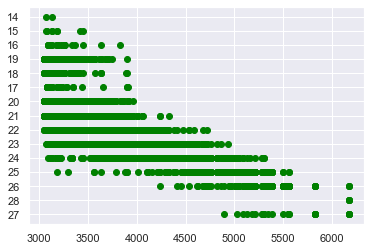

In [46]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.scatter(dfRioTrain['Score'].astype(float),dfRioTrain['cle'], color='green')

In [35]:
predictions = reg_test.predict(dfRioTest[['cle']])
result = mean_squared_error(dfRioTest['Score'], predictions)
result

68778.01141514239

In [39]:

math.sqrt(result)

262.25562227556225

In [47]:
kmean= KMeans(init= 'random' , n_clusters= 5 , max_iter= 5000 ,n_init= 1500 )
cluster = kmean.fit(dfRioTrain)
c=cluster.labels_
centers = kmean.cluster_centers_

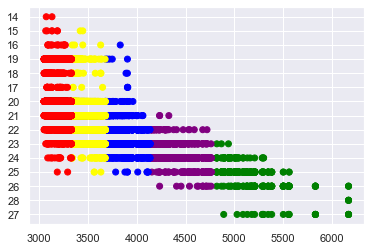

In [48]:
LABEL_COLOR_MAP = {0 : 'green', 1 : 'blue', 2 : 'red', 3 : 'purple', 4 : 'yellow', 5 : 'pink'}
label_color = [LABEL_COLOR_MAP[l] for l in c]

plt.scatter(dfRioTrain['Score'].astype(float),dfRioTrain['cle'], c=label_color)